In [1]:
import os
import random

import pickle
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import tensorflow as tf
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, MaxNLocator


custom_seed = 42
np.random.seed(custom_seed)
tf.random.set_seed(custom_seed)

In [2]:
problem = "tensorial_problem"

In [3]:
data_folder = r'C:\Users\usuario\Desktop\rmunozTMELab\PGNNIV-to-Continuum-Problems\data'
results_folder = rf'C:\Users\usuario\Desktop\rmunozTMELab\PGNNIV-to-Continuum-Problems\results\tensorial_problem_results'

print(data_folder)
print(results_folder)

C:\Users\usuario\Desktop\rmunozTMELab\PGNNIV-to-Continuum-Problems\data
C:\Users\usuario\Desktop\rmunozTMELab\PGNNIV-to-Continuum-Problems\results\tensorial_problem_results


In [4]:
data_path = os.path.join(data_folder, f'{problem}_data.pkl')
first_training_result_path = os.path.join(results_folder, f'{problem}_first_train.pkl')
second_training_result_path = os.path.join(results_folder, f'{problem}_new_train.pkl')

print(data_path)
print(first_training_result_path)
print(second_training_result_path)

C:\Users\usuario\Desktop\rmunozTMELab\PGNNIV-to-Continuum-Problems\data\tensorial_problem_data.pkl
C:\Users\usuario\Desktop\rmunozTMELab\PGNNIV-to-Continuum-Problems\results\tensorial_problem_results\tensorial_problem_first_train.pkl
C:\Users\usuario\Desktop\rmunozTMELab\PGNNIV-to-Continuum-Problems\results\tensorial_problem_results\tensorial_problem_new_train.pkl


In [5]:
# Load data
with open(data_path, 'rb') as f:
    data = pickle.load(f)

# Load first training
with open(first_training_result_path, 'rb') as f:
    results_first_train_pkl = pickle.load(f)

results_first_train = results_first_train_pkl['training']
predictions_predictive_first_train = results_first_train_pkl['predictions_pred']
predictions_explanatory_first_train = results_first_train_pkl['predictions_exp']

# Load second training
with open(second_training_result_path, 'rb') as f:
    results_second_train_pkl = pickle.load(f)

results_second_train = results_second_train_pkl['training']
predictions_predictive_second_train = results_second_train_pkl['predictions_pred']
predictions_explanatory_second_train = results_second_train_pkl['predictions_exp']

In [6]:
n_data = data['n_data']
n_discretization = data['n_discretization']
x_step_size = data['x_step_size']
y_step_size = data['y_step_size']

Functions that are necessary 

In [7]:
# Finite difference convolutional operator to derivate in x axis
def Dx(f, x_step_size=x_step_size):
    Dx = tf.constant([[-1, +1], 
                      [-1, +1]], 
                     dtype=tf.float32)/(2*x_step_size)

    f_reshaped = tf.expand_dims(f[:, :, :], axis=-1)    
    Dx = tf.expand_dims(tf.expand_dims(Dx, axis=-1), axis=-1)
    dfdx = tf.nn.conv2d(f_reshaped, Dx, strides=[1, 1, 1, 1], padding='VALID', name='dfdx')
    return tf.squeeze(dfdx, axis=-1)

# Finite difference convolutional operator to derivate in y axis
def Dy(f, y_step_size=y_step_size):
    Dy = tf.constant([[+1, +1], 
                      [-1, -1]],  
                     dtype=tf.float32)/(-2*y_step_size)

    f_reshaped = tf.expand_dims(f[:, :, :], axis=-1)    
    Dy = tf.expand_dims(tf.expand_dims(Dy, axis=-1), axis=-1)
    dfdy = tf.nn.conv2d(f_reshaped, Dy, strides=[1, 1, 1, 1], padding='VALID', name='dfdy')
    return tf.squeeze(dfdy, axis=-1)

# Convolutional operator to do the mean between two elements of a mesh in x axis
def Mx(f):
    Mx = tf.constant([[+1, +1]], 
                     dtype=tf.float32)/(2)

    f_reshaped = tf.expand_dims(f[:, :, :], axis=-1)    
    Mx = tf.expand_dims(tf.expand_dims(Mx, axis=-1), axis=-1)
    x_avg = tf.nn.conv2d(f_reshaped, Mx, strides=[1, 1, 1, 1], padding='VALID', name='Mx')
    return tf.squeeze(x_avg, axis=-1)

# Convolutional operator to do the mean between two elements of a mesh in y axis
def My(f):
    My = tf.constant([[+1], 
                      [+1]], 
                     dtype=tf.float32)/(2)

    f_reshaped = tf.expand_dims(f[:, :, :], axis=-1)    
    My = tf.expand_dims(tf.expand_dims(My, axis=-1), axis=-1)
    y_avg = tf.nn.conv2d(f_reshaped, My, strides=[1, 1, 1, 1], padding='VALID', name='My')
    return tf.squeeze(y_avg, axis=-1)

In [8]:
def smooth_curve(data, window_size=50):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode='valid')

def cm_to_in(cm):
    return cm * 0.393701

def normalize_list(lst):
    max_value = max(lst)
    return [x / max_value for x in lst]

Graphics parameters

In [9]:
linewidth = 1.5  
title_fontsize = 14  
label_fontsize = 14  
legend_fontsize = 12 
tick_fontsize = 11  

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

posX = cm_to_in(10) # posición de la esquina inferior izquierda de la imagen en X
posY = cm_to_in(10) # posición de la esquina inferior izquierda de la imagen en Y
width = cm_to_in(12)  # ancho de la imagen
height = cm_to_in(8) # alto de la imagen

color = [0.1, 0, 0.8]  # triplete RGB, valores entre 0 y 1
subplot_adjust_left = cm_to_in(0.15)
subplot_adjust_bottom = cm_to_in(0.15)

Training curves

In [10]:
train_total_loss_list = results_first_train['train_total_loss_list'] + results_second_train['train_total_loss_list']
test_total_loss_list = results_first_train['test_total_loss_list'] + results_second_train['test_total_loss_list']

train_total_MSE_list = results_first_train['train_total_MSE_list'] + results_second_train['train_total_MSE_list']
test_total_MSE_list = results_first_train['test_total_MSE_list'] + results_second_train['test_total_MSE_list']

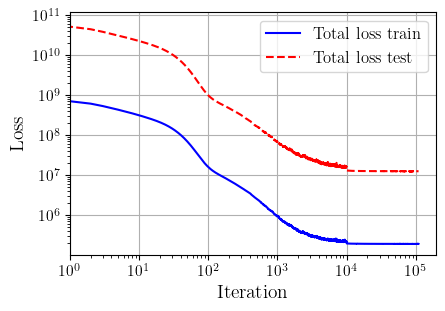

In [11]:
plt.figure(figsize=(width, height))

plt.plot(smooth_curve(train_total_loss_list), label='Total loss train', color='blue', linestyle='-')
plt.plot(smooth_curve(test_total_loss_list), label='Total loss test', color='red', linestyle='--')

plt.xlabel('Iteration', fontsize=label_fontsize)
plt.ylabel('Loss', fontsize=label_fontsize)

plt.grid(True)
plt.legend(loc='upper right', fontsize=legend_fontsize)
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.xscale('log')
plt.yscale('log')
plt.xlim(left=1) 

plt.show()

In [12]:
train_e_loss_list = results_first_train['train_e_loss_list'] + results_second_train['train_e_loss_list']
train_pi1_loss_list = results_first_train['train_pi1_loss_list'] + results_second_train['train_pi1_loss_list']
train_pi2_loss_list = results_first_train['train_pi2_loss_list'] + results_second_train['train_pi2_loss_list']
train_pi3_loss_list = results_first_train['train_pi3_loss_list'] + results_second_train['train_pi3_loss_list']

test_e_loss_list = results_first_train['test_e_loss_list'] + results_second_train['test_e_loss_list']
test_pi1_loss_list = results_first_train['test_pi1_loss_list'] + results_second_train['test_pi1_loss_list']
test_pi2_loss_list = results_first_train['test_pi2_loss_list'] + results_second_train['test_pi2_loss_list']
test_pi3_loss_list = results_first_train['test_pi3_loss_list'] + results_second_train['test_pi3_loss_list']

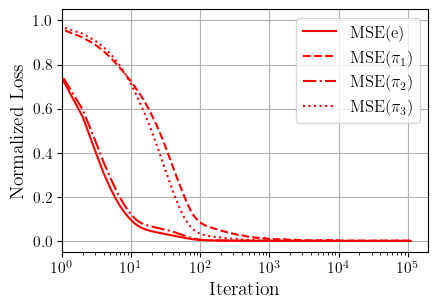

In [13]:
plt.figure(figsize=(width, height))

plt.plot(normalize_list(smooth_curve(train_e_loss_list)), label=r'MSE(e) ', color='red', linestyle='-')
plt.plot(normalize_list(smooth_curve(train_pi1_loss_list)), label=r'MSE($\pi_1$) ', color='red', linestyle='--')
plt.plot(normalize_list(smooth_curve(train_pi2_loss_list)), label=r'MSE($\pi_2$) ', color='red', linestyle='-.')
plt.plot(normalize_list(smooth_curve(train_pi3_loss_list)), label=r'MSE($\pi_3$) ', color='red', linestyle=':')

plt.xlabel('Iteration', fontsize=label_fontsize)
plt.ylabel('Normalized Loss', fontsize=label_fontsize)

plt.grid(True)
plt.legend(loc='upper right', fontsize=legend_fontsize)
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.xscale('log')
plt.xlim(left=1) 

plt.show()

Results validation

In [14]:
def relative_error_stats(validation, prediction, dx=x_step_size, dy=y_step_size):

    prediction_error = np.sqrt((np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx) /
                                np.trapz(np.trapz((validation)**2, dx=dy), dx=dx)))

    min = np.min(prediction_error)
    max = np.max(prediction_error)
    Q1 = np.percentile(prediction_error, 25)
    Q2 = np.percentile(prediction_error, 50)
    Q3 = np.percentile(prediction_error, 75)

    print(f"Min: {min:.2e}")
    print(f"Max: {max:.2e}")
    print(f"First quartile (Q1): {Q1:.2e}")
    print(f"Second quartile (Q2): {Q2:.2e}")
    print(f"Third quartile (Q3): {Q3:.2e}")

def absolute_error_stats(validation, prediction, dx=x_step_size, dy=y_step_size):
    prediction_error = np.sqrt(np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx))

    min = np.min(prediction_error)
    max = np.max(prediction_error)
    Q1 = np.percentile(prediction_error, 25)
    Q2 = np.percentile(prediction_error, 50)
    Q3 = np.percentile(prediction_error, 75)

    print(f"Min: {min:.2e}")
    print(f"Max: {max:.2e}")
    print(f"First quartile (Q1): {Q1:.2e}")
    print(f"Second quartile (Q2): {Q2:.2e}")
    print(f"Third quartile (Q3): {Q3:.2e}")

Solution $u(x, y)$

In [15]:
validation_solution = data['y_val']
predicted_solution = predictions_predictive_second_train
solution_diff = np.mean(np.abs(predicted_solution - validation_solution), axis=0)

relative_error_stats(validation=validation_solution, prediction=predicted_solution)

Min: 1.83e-05
Max: 1.16e-03
First quartile (Q1): 5.87e-05
Second quartile (Q2): 8.43e-05
Third quartile (Q3): 1.17e-04


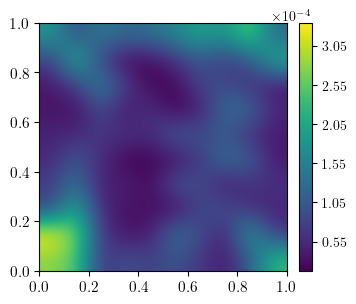

In [16]:
plt.figure(figsize=(height*1.2, height))

# Plot of the image
plt.imshow(solution_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

# Colorbar and axis configuration
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
ticks = cbar.get_ticks()
new_ticks = (ticks + ticks[1]/10)
cbar.set_ticks(new_ticks[1:-1])

# Other parameters
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

# Show the image
plt.show()

Diffusivity $K(x, y)$

In [17]:
validation_K = My(Mx(tf.convert_to_tensor(data['k_val'], dtype=tf.float32)))
predicted_K = predictions_explanatory_second_train

Kxx_val = validation_K[0, 0, :, :].numpy()  
Kxy_val = validation_K[0, 1, :, :].numpy()
Kyy_val = validation_K[0, 3, :, :].numpy()

Kxx_pred = predicted_K[0, :, :]
Kxy_pred = predicted_K[1, :, :]
Kyy_pred = predicted_K[3, :, :]

Kxx_diff = np.abs(Kxx_pred - Kxx_val)
Kxy_diff = np.abs(Kxy_pred - Kxy_val)
Kyy_diff = np.abs(Kyy_pred - Kyy_val)

relative_error_stats(validation=validation_K, prediction=predicted_K)

Min: 6.03e-02
Max: 2.44e-01
First quartile (Q1): 1.08e-01
Second quartile (Q2): 1.24e-01
Third quartile (Q3): 1.54e-01


In [18]:
def relative_error_K_tensorial(validation, prediction):

    expanded_prediction = tf.tile(tf.expand_dims(prediction, axis=0), tf.constant([2000, 1, 1, 1]))

    numerator = np.trapz(np.trapz((validation[:, 0] - expanded_prediction[:, 0])**2)) + np.trapz(np.trapz((validation[:, 1] - expanded_prediction[:, 1])**2)) + np.trapz(np.trapz((validation[:, 2] - expanded_prediction[:, 2])**2)) + np.trapz(np.trapz((validation[:, 3] - expanded_prediction[:, 3])**2))
    denominator = np.trapz(np.trapz((validation[:, 0])**2)) + np.trapz(np.trapz((validation[:, 1])**2)) + np.trapz(np.trapz((validation[:, 2])**2)) + np.trapz(np.trapz((validation[:, 3])**2))
    prediction_error = np.sqrt(numerator/denominator)

    min = np.min(prediction_error)
    max = np.max(prediction_error)
    Q1 = np.percentile(prediction_error, 25)
    Q2 = np.percentile(prediction_error, 50)
    Q3 = np.percentile(prediction_error, 75)

    print(f"Min: {min:.2e}")
    print(f"Max: {max:.2e}")
    print(f"First quartile (Q1): {Q1:.2e}")
    print(f"Second quartile (Q2): {Q2:.2e}")
    print(f"Third quartile (Q3): {Q3:.2e}")

relative_error_K_tensorial(validation=validation_K, prediction=predicted_K)

Min: 1.25e-01
Max: 1.25e-01
First quartile (Q1): 1.25e-01
Second quartile (Q2): 1.25e-01
Third quartile (Q3): 1.25e-01


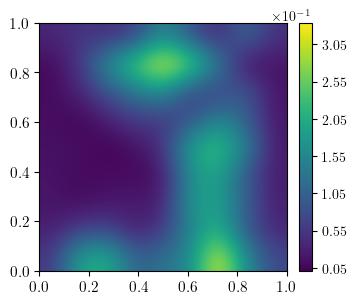

In [19]:
plt.figure(figsize=(height*1.2, height))

# Plot of the image
plt.imshow(Kxx_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

# Colorbar and axis configuration
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.005)
cbar.set_ticks(new_ticks[0:-1])

# Other parameters
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

# Show the image
plt.show()

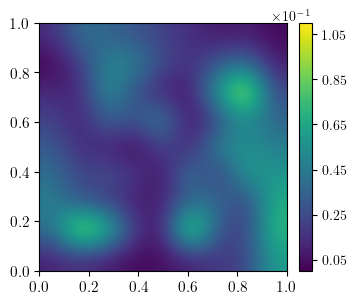

In [20]:
plt.figure(figsize=(height*1.2, height))

# Plot of the image
plt.imshow(Kxy_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

# Colorbar and axis configuration
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.005)
cbar.set_ticks(new_ticks[0:-1])

# Other parameters
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

# Show the image
plt.show()

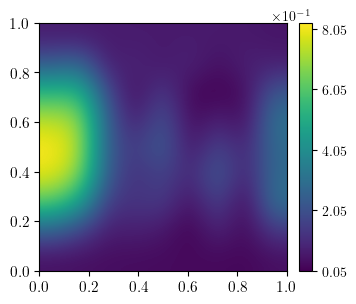

In [21]:
plt.figure(figsize=(height*1.2, height))

# Plot of the image
plt.imshow(Kyy_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

# Colorbar and axis configuration
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.005)
cbar.set_ticks(new_ticks[0:-1])

# Other parameters
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

# Show the image
plt.show()

Flux $q_x$

In [22]:
validation_qx = My(Mx(tf.convert_to_tensor(data['qx_val'], dtype=tf.float32)))
predicted_qx = predicted_K[0]*Dx(predictions_predictive_second_train).numpy() + predicted_K[1]*Dx(predictions_predictive_second_train).numpy()
qx_diff = np.mean(np.abs(predicted_qx - validation_qx), axis=0)

relative_error_stats(validation=validation_qx, prediction=predicted_qx)

Min: 5.30e-02
Max: 1.69e-01
First quartile (Q1): 6.01e-02
Second quartile (Q2): 6.98e-02
Third quartile (Q3): 8.69e-02


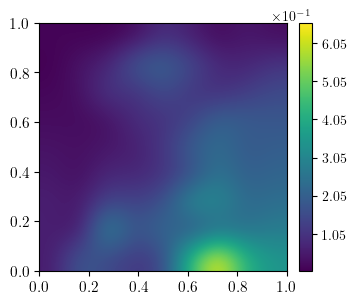

In [23]:
plt.figure(figsize=(height*1.2, height))

# Plot of the image
plt.imshow(qx_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

# Colorbar and axis configuration
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.005)
cbar.set_ticks(new_ticks[1:-1])

# Other parameters
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

# Show the image
plt.show()

Flux $q_y$

In [24]:
validation_qy = My(Mx(tf.convert_to_tensor(data['qy_val'], dtype=tf.float32)))
predicted_qy = predicted_K[2]*Dy(predictions_predictive_second_train).numpy() + predicted_K[3]*Dy(predictions_predictive_second_train).numpy()
qy_diff = np.mean(np.abs(predicted_qy - validation_qy), axis=0)

relative_error_stats(validation=validation_qy, prediction=predicted_qy)

Min: 1.53e-01
Max: 2.77e-01
First quartile (Q1): 1.60e-01
Second quartile (Q2): 1.75e-01
Third quartile (Q3): 2.00e-01


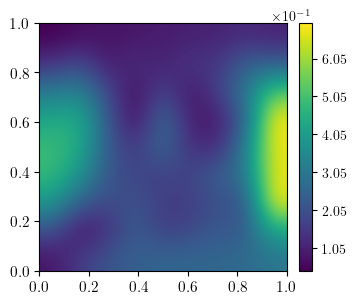

In [25]:
plt.figure(figsize=(height*1.2, height))

# Plot of the image
plt.imshow(qy_diff, interpolation='bicubic', extent=[0, 1, 0, 1])

# Colorbar and axis configuration
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.005)
cbar.set_ticks(new_ticks[1:-1])

# Other parameters
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

# Show the image
plt.show()

Principal directions

In [41]:
val_K = validation_K.numpy()
val_K = val_K.transpose(0, 2, 3, 1).reshape(validation_K.shape[0], *validation_K.shape[-2:], 2, 2)
eigenvalues_val, eigenvectors_val = np.linalg.eig(val_K)

pred_K = predicted_K
pred_K = pred_K.transpose(1, 2, 0).reshape(*validation_K.shape[-2:], 2, 2)
eigenvalues_pred, eigenvectors_pred = np.linalg.eig(pred_K)

Dx_val = eigenvectors_val[0, :, :, 0, 0]
Dy_val = eigenvectors_val[0, :, :, 1, 0]

Dx_pred = eigenvectors_pred[:, :, 0, 0]
Dy_pred = eigenvectors_pred[:, :, 1, 0]

angles_val = np.arctan2(Dy_val, Dx_val)
angles_pred = np.arctan2(Dy_pred, Dx_pred)
angle_diff = angles_pred - angles_val

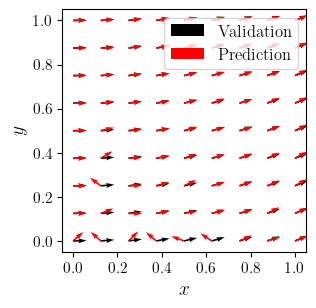

In [51]:
x = np.linspace(0, 1, validation_K.shape[-2])
y = np.linspace(0, 1, validation_K.shape[-1])

plt.figure(figsize=(height, height))

# Plot of the quiverplots
plt.quiver(x, y, Dx_val, Dy_val, color='black', label=r'Validation')
plt.quiver(x, y, Dx_pred, Dy_pred, color='red', label=r'Prediction')

# Axis configuration and other parameters
plt.xlabel('$x$', fontsize=label_fontsize)
plt.ylabel('$y$', fontsize=label_fontsize)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=tick_fontsize)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=tick_fontsize)
plt.legend(loc='upper right', fontsize=legend_fontsize)
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# Show the image
plt.show()

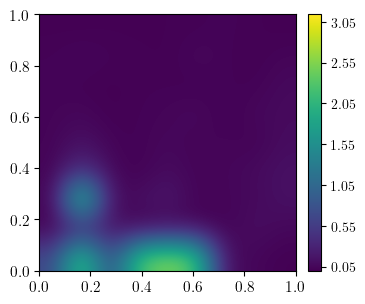

In [47]:
plt.figure(figsize=(height*1.2, height))

# Plot of the image
plt.imshow(np.flipud(np.abs(angle_diff)), interpolation='bicubic', vmin=0, vmax=np.pi, extent=[0, 1, 0, 1])

# Colorbar and axis configuration
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.formatter = ScalarFormatter(useMathText=True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
ticks = cbar.get_ticks()
new_ticks = (ticks + 0.05)
cbar.set_ticks(new_ticks[0:-1])

# Other parameters
plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()

# Show the image
plt.show()

Predicted solutions

In [52]:
def calculate_error(validation_data, predicted_data):
    numerator = np.trapz(np.trapz((validation_data - predicted_data)**2))
    denominator = np.trapz(np.trapz((validation_data)**2))

    if np.all(denominator == 0):
        result = np.sqrt(numerator)
    else:
        result = np.sqrt(numerator / denominator)
    return result

def relative_error(validation, prediction):
    return (np.trapz(np.trapz((validation - prediction)**2))/np.trapz(np.trapz((validation)**2)))

solution


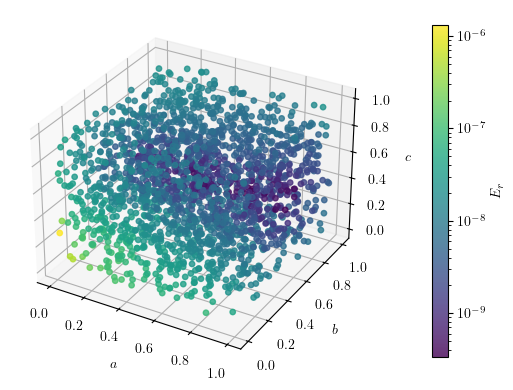

qx


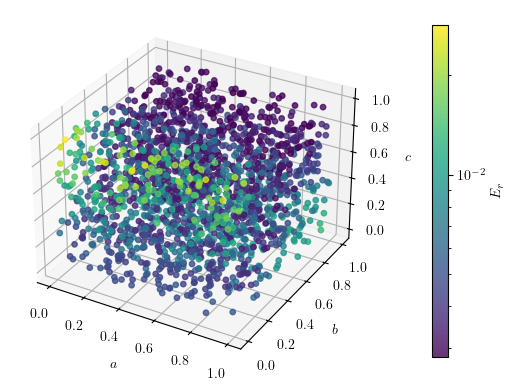

qy


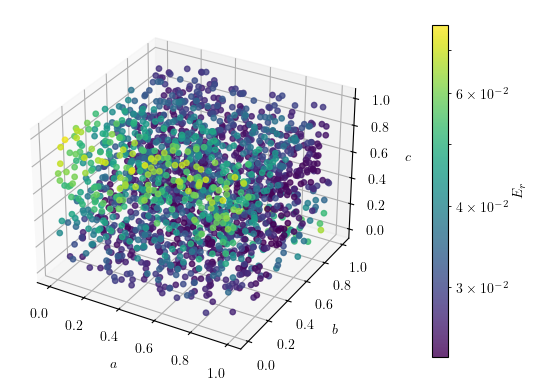

In [53]:
E_solution = relative_error(validation_solution, predicted_solution)
E_qx = relative_error(validation_qx, predicted_qx)
E_qy = relative_error(validation_qy, predicted_qy)

a = data['a_val']
b = data['b_val']
c = data['c_val']

def plot_error(a, b, c, error, variable):
    
    print(variable)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(a, b, c, c=error, cmap='viridis', s=15, alpha=0.8, norm=mcolors.LogNorm())
    cbar = plt.colorbar(sc, pad=0.12, shrink=0.9)
    cbar.set_label('$E_r$')

    ax.set_xlabel('$a$')
    ax.set_ylabel('$b$')
    ax.set_zlabel('$c$')

    plt.show()

plot_error(a=a, b=b, c=c, error=E_solution, variable='solution')
plot_error(a=a, b=b, c=c, error=E_qx, variable='qx')
plot_error(a=a, b=b, c=c, error=E_qy, variable='qy')